[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1w-RBJ1c4S7dEcihNH1LxbDkxC5SLpmYv)

<a href="https://www.kaggle.com/jacobj215/pneumonia-classification" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

### Import Libraries

In [1]:
import os 
import torch 
import torch.nn as nn
import torchmetrics
import torchvision
from torchvision.transforms import transforms
import pytorch_lightning as pl
from torch.utils.data import Dataset, DataLoader
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
from sklearn.model_selection import train_test_split

import pydicom
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pneumonia_dataset import PneumoniaDataset

### Data Preperation

In [2]:
# Define the data directories and labels file
data_dir = "Data/rsna-pneumonia-detection-challenge/stage_2_train_images/"
labels = "Data/rsna-pneumonia-detection-challenge/stage_2_train_labels.csv"

In [3]:
# Read in data 
labels_df = pd.read_csv(labels)
labels_df.shape

(30227, 6)

In [4]:
labels_df.head()

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1


In [5]:
labels_df = labels_df[["patientId", "Target"]]
labels_df.head()

,patientId,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,0
4,00436515-870c-4b36-a041-de91049b9ab4,1


In [6]:
# Data transormation pipelines for data preprocessing
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5),
    transforms.RandomAffine(degrees=(-5,5), translate=(0, 0.05), scale=(0.9, 1.1)),
    transforms.RandomResizedCrop((224, 224), scale=(0.25, 1), antialias=True)
])

val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(0.5, 0.5)
])

In [7]:
# Define variables
batch_size = 32
num_workers = 4

# Split the labels into train and validation sets
train_labels, val_labels = train_test_split(labels_df.values, test_size=0.1, random_state=42)


# Get the paths for train and validation images
train_paths = [os.path.join(data_dir, image[0] + ".dcm") for image in train_labels]
val_paths = [os.path.join(data_dir, image[0] + ".dcm") for image in val_labels]


# Create train dataset
train_dataset = PneumoniaDataset(train_paths, train_labels[:, 1], transforms=train_transforms)

# Create validation dataset
val_dataset = PneumoniaDataset(val_paths, val_labels[:, 1], transforms=val_transforms)

##### Preview images

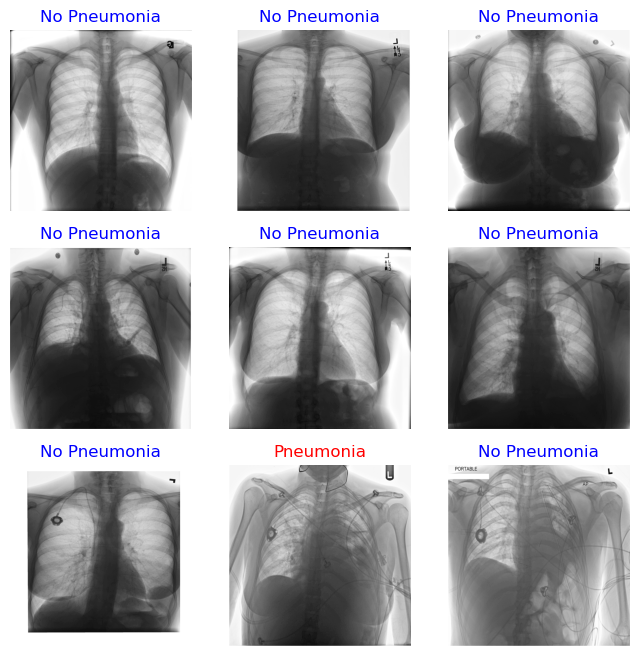

In [8]:
import random

# Create a 3x3 grid for image preview
plt.figure(figsize=(8, 8))
indices = random.sample(range(20, len(train_paths)), 9)

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.grid(False)
    
    img_dcm = pydicom.dcmread(f'{train_paths[i+20]}')
    img_np = img_dcm.pixel_array
    plt.imshow(img_np, cmap="bone")

    if train_labels[i+20][1] == 1:
        plt.title("Pneumonia", color="red")
    else:
        plt.title("No Pneumonia", color="blue")

    plt.axis("off")

In [9]:
# Create data loaders
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=True
) 

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size,
    num_workers=num_workers,
    shuffle=False
)     



### Create Model

In [10]:
class PneumoniaModel(pl.LightningModule):
    def __init__(self, weight=3):
        super().__init__()
        # Define the model architecture
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(in_features=64, out_features=128),
            nn.ReLU(),
            nn.Linear(128, 1)
        )

        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([weight]))

        self.train_acc = torchmetrics.Accuracy(task='binary')
        self.val_acc = torchmetrics.Accuracy(task='binary')

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        outputs = self(x)
        y = y.float().unsqueeze(1)  # Ensure target tensor has the same size as input tensor
        loss = self.loss_fn(outputs, y)
        self.log("train_loss", loss, on_step=True, on_epoch=True)
        self.log("train_acc", self.train_acc(outputs.sigmoid(), y), on_step=True, on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        outputs = self(x)
        y = y.float().unsqueeze(1)  # Ensure target tensor has the same size as input tensor
        loss = self.loss_fn(outputs, y)
        self.log("val_loss", loss, on_step=True, on_epoch=True)
        self.log("val_acc", self.val_acc(outputs.sigmoid(), y), on_step=True, on_epoch=True)

    def configure_optimizers(self):
        return self.optimizer


In [11]:
# Create checkpoint
checkpoint_callback = ModelCheckpoint(
    monitor="val_acc",
    dirpath="./models",
    filename="best_model",
    save_top_k=1,
    mode="max"
)

In [12]:
# Initialize the model
model = PneumoniaModel()

In [13]:
# Create PyTorch Lighting Trainer
trainer = pl.Trainer(
    devices=1,
    accelerator="gpu",
    logger=TensorBoardLogger(save_dir="./logs"), 
    log_every_n_steps=1,
    callbacks=checkpoint_callback,
    max_epochs=10
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [14]:
trainer.fit(
    model,
    train_loader,
    val_loader
)


  | Name      | Type              | Params
------------------------------------------------
0 | model     | Sequential        | 27.3 K
1 | loss_fn   | BCEWithLogitsLoss | 0     
2 | train_acc | BinaryAccuracy    | 0     
3 | val_acc   | BinaryAccuracy    | 0     
------------------------------------------------
27.3 K    Trainable params
0         Non-trainable params
27.3 K    Total params
0.109     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


### Load Model

In [16]:
device = 'mps' if torch.backends.mps.is_available() else 'cpu'

In [17]:
model = PneumoniaModel.load_from_checkpoint(checkpoint_callback.best_model_path)
model.eval()
model.to(device)

PneumoniaModel(
  (model): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): AdaptiveAvgPool2d(output_size=1)
    (7): Flatten(start_dim=1, end_dim=-1)
    (8): Linear(in_features=64, out_features=128, bias=True)
    (9): ReLU()
    (10): Linear(in_features=128, out_features=1, bias=True)
  )
  (loss_fn): BCEWithLogitsLoss()
  (train_acc): BinaryAccuracy()
  (val_acc): BinaryAccuracy()
)

### Model Evaluation

In [65]:
preds, labels = [], []

with torch.no_grad():
  for data, label in val_dataset:
    data = data.to(device).float().unsqueeze(0)
    pred = torch.sigmoid(model(data)[0].cpu())
    preds.append(pred)
    labels.append(label)
  preds = torch.tensor(preds)
  labels = torch.tensor(labels).int()

  acc = torchmetrics.Accuracy(task="binary")(preds, labels)
  precision = torchmetrics.Precision(task="binary")(preds, labels)
  recall = torchmetrics.Recall(task="binary")(preds, labels)
  cm = torchmetrics.ConfusionMatrix(task="binary", num_class=2)(preds, labels)


print(f"Val Accuracy: {acc}")
print(f"Val Precision: {precision}")
print(f"Val Recall: {recall}")
print(f"Confusion Matrix {cm}")

Val Accuracy: 0.6470393538475037
Val Precision: 0.4511125981807709
Val Recall: 0.72559654712677
Confusion Matrix tensor([[1287,  814],
        [ 253,  669]])


### Create Custom Resnet18 Model

In [87]:
class PneumoniaResnet18(pl.LightningModule):
    def __init__(self, weight=3):
        super().__init__()
        # Load the resnet18 model
        self.model = torchvision.models.resnet18()
        # Change conv1 from 3 to 1 input channels
        self.model.conv1 = torch.nn.Conv2d(
            in_channels=1,
            out_channels=64,
            kernel_size=(7, 7),
            stride=(2, 2),
            padding=(3, 3),
            bias=False
        )
        # Change out_features of the last fully connected layer from 1000 to 1
        self.model.fc = torch.nn.Linear(
            in_features=512,
            out_features=1
        )

        self.optimizer = torch.optim.Adam(self.parameters(), lr=1e-4)
        self.loss_fn = torch.nn.BCEWithLogitsLoss(pos_weight=torch.tensor([weight]))
        self.train_acc = torchmetrics.Accuracy(task="binary")
        self.val_acc = torchmetrics.Accuracy(task="binary")

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        outputs = self(x)
        y = y.float().unsqueeze(1) # Ensure target tensor has the same size as the input tensor
        loss = self.loss_fn(outputs, y)
        self.log("train_loss", loss, on_epoch=True)
        self.log("train_acc", self.train_acc(outputs.sigmoid(), y), on_epoch=True)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        outputs = self(x)
        y = y.float().unsqueeze(1) # Ensure target tensor has the same size as the input tensor
        loss = self.loss_fn(outputs, y)
        self.log("val_loss", loss, on_epoch=True)
        self.log("val_acc", self.val_acc(outputs.sigmoid(), y), on_epoch=True)

    def configure_optimizers(self):
        return self.optimizer

In [88]:
# Create checkpoint
resnet18_checkpoint_callback = ModelCheckpoint(
    monitor="val_acc",
    dirpath="./resnet18",
    filename="best_model",
    save_top_k=1,
    mode="max"
)

In [89]:
resnet18_model = PneumoniaResnet18()

In [90]:
# Create PyTorch Lighting Trainer
resnet18_trainer = pl.Trainer(
    devices=1,
    accelerator="gpu",
    logger=TensorBoardLogger(save_dir="./logs/restnet18"), 
    log_every_n_steps=1,
    callbacks=resnet18_checkpoint_callback,
    max_epochs=35
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [91]:
resnet18_trainer.fit(
    resnet18_model,
    train_loader,
    val_loader)


  | Name      | Type              | Params
------------------------------------------------
0 | model     | ResNet            | 11.2 M
1 | loss_fn   | BCEWithLogitsLoss | 0     
2 | train_acc | BinaryAccuracy    | 0     
3 | val_acc   | BinaryAccuracy    | 0     
------------------------------------------------
11.2 M    Trainable params
0         Non-trainable params
11.2 M    Total params
44.683    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=35` reached.


### Model Evaluation

In [93]:
resnet18_model = PneumoniaResnet18.load_from_checkpoint(resnet18_checkpoint_callback.best_model_path)
resnet18_model.eval()
resnet18_model.to(device)

PneumoniaResnet18(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

In [94]:
preds, labels = [], []

with torch.no_grad():
  for data, label in val_dataset:
    data = data.to(device).float().unsqueeze(0)
    pred = torch.sigmoid(resnet18_model(data)[0].cpu())
    preds.append(pred)
    labels.append(label)
  preds = torch.tensor(preds)
  labels = torch.tensor(labels).int()

  acc = torchmetrics.Accuracy(task="binary")(preds, labels)
  precision = torchmetrics.Precision(task="binary")(preds, labels)
  recall = torchmetrics.Recall(task="binary")(preds, labels)
  cm = torchmetrics.ConfusionMatrix(task="binary", num_class=2)(preds, labels)


print(f"Val Accuracy: {acc}")
print(f"Val Precision: {precision}")
print(f"Val Recall: {recall}")
print(f"Confusion Matrix {cm}")

Val Accuracy: 0.809791624546051
Val Precision: 0.6602031588554382
Val Recall: 0.7754880785942078
Confusion Matrix tensor([[1733,  368],
        [ 207,  715]])


### Model Interpretation

In [95]:
class PneumoniaResnet18(pl.LightningModule):
    def __init__(self):
        super().__init__()
        # Load the resnet18 model
        self.model = torchvision.models.resnet18()
        # Change conv1 from 3 to 1 input channels
        self.model.conv1 = torch.nn.Conv2d(
            in_channels=1, 
            out_channels=64,
            kernel_size=(7, 7), stride=(2, 2), 
            padding=(3, 3), 
            bias=False
        )
        # Change out_features of the last fully connected layer from 1000 to 1
        self.model.fc = torch.nn.Linear(
            in_features=512, 
            out_features=1
        )
        # Extract the feature map by removing the last two layers (average pooling and fully connected)
        self.feature_map = torch.nn.Sequential(*list(self.model.children())[:-2])

    def forward(self, data):
        # Get the feature map by passing the input data through the layers before the final two layers
        feature_map = self.feature_map(data)
        # Perform adaptive average pooling to convert the feature map to a 1x1 size
        avg_pool_output = torch.nn.functional.adaptive_avg_pool2d(input=feature_map, output_size=(1, 1))
        # Flatten the output to prepare for the final fully connected layer
        avg_output_flattened = torch.flatten(avg_pool_output)
        # Forward pass through the final fully connected layer to get the predictions
        pred = self.model.fc(avg_output_flattened)
        return pred, feature_map

In [97]:
resnet18_model = PneumoniaResnet18.load_from_checkpoint(resnet18_checkpoint_callback.best_model_path, strict=False)
resnet18_model.eval()
resnet18_model.to(device)

/Users/jacob/miniforge3/envs/mlenv/lib/python3.8/site-packages/pytorch_lightning/core/saving.py:160: UserWarning: Found keys that are in the model state dict but not in the checkpoint: ['feature_map.0.weight', 'feature_map.1.weight', 'feature_map.1.bias', 'feature_map.1.running_mean', 'feature_map.1.running_var', 'feature_map.4.0.conv1.weight', 'feature_map.4.0.bn1.weight', 'feature_map.4.0.bn1.bias', 'feature_map.4.0.bn1.running_mean', 'feature_map.4.0.bn1.running_var', 'feature_map.4.0.conv2.weight', 'feature_map.4.0.bn2.weight', 'feature_map.4.0.bn2.bias', 'feature_map.4.0.bn2.running_mean', 'feature_map.4.0.bn2.running_var', 'feature_map.4.1.conv1.weight', 'feature_map.4.1.bn1.weight', 'feature_map.4.1.bn1.bias', 'feature_map.4.1.bn1.running_mean', 'feature_map.4.1.bn1.running_var', 'feature_map.4.1.conv2.weight', 'feature_map.4.1.bn2.weight', 'feature_map.4.1.bn2.bias', 'feature_map.4.1.bn2.running_mean', 'feature_map.4.1.bn2.running_var', 'feature_map.5.0.conv1.weight', 'feature_

PneumoniaResnet18(
  (model): ResNet(
    (conv1): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, t

In [98]:
def cam(model, img):
    # Run the model on the input image and get the predictions and features
    with torch.no_grad():
        pred, features = model(img.unsqueeze(0))
    # Reshape the features to a 2D tensor (512, 49) for matrix multiplication with weights
    features = features.reshape((512, 49))
    # Extract the weights of the last fully connected layer (output layer)
    weight_params = list(model.model.fc.parameters())[0]
    # Detach the weights to avoid gradients from being computed during CAM calculation
    weight = weight_params[0].detach()

    # Perform matrix multiplication between weights and features to get the CAM
    cam = torch.matmul(weight, features)
    # Reshape the CAM to match the size of the feature map (7x7) and move to CPU
    cam_img = cam.reshape(7, 7).cpu()
    return cam_img, torch.sigmoid(pred)

In [102]:
def visualize(img, cam, pred):
    # Move the input image and CAM tensor to CPU for visualization
    img = img[0].cpu()
    cam = torchvision.transforms.functional.resize(cam.unsqueeze(0), (224, 224))[0]

    # Create a figure with two subplots (original image and image with CAM)
    fig, axis = plt.subplots(1, 2)
    # Plot the original image in the first subplot
    axis[0].imshow(img, cmap="bone")
    # Plot the original image again in the second subplot
    axis[1].imshow(img, cmap="bone")
    # Overlay the CAM on the second subplot with alpha blending using the "jet" colormap
    axis[1].imshow(cam, alpha=0.5, cmap="jet")
    # Add a title to the second subplot indicating the predicted class based on the threshold (0.5)
    plt.title(pred > 0.5)


In [118]:
# Load the last image from the validation dataset and move it to the specified device (e.g., GPU).
img = val_dataset[12][0].to(device)

# Perform Class Activation Mapping (CAM) on the loaded image using the trained model.
activation_map, pred = cam(resnet18_model, img)

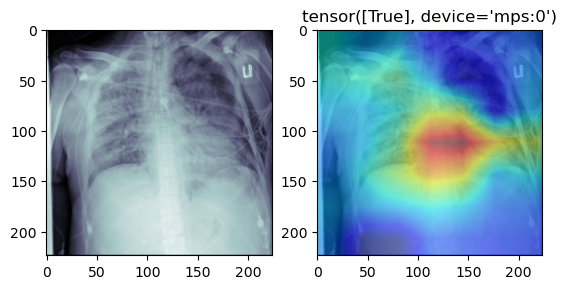

In [119]:
visualize(img, activation_map, pred)